# 🧪 Laborator 3: Stress-Testing & Generalizare
## Impactul Zgomotului (Noise) și al Tehnicilor SMOTE asupra Overfitting-ului

**Student:** *Perebinos Daniel*
**Obiectiv:** Analiza modului în care calitatea datelor influențează capacitatea de generalizare a modelelor de clasificare.

---

### 🎯 Metodologie

1. **Noise Injection** — introducem erori intenționate în etichetele de antrenament
   (5%, 25%, 50%, 75%) pentru a forța modelul să "memoreze" informații greșite.

2. **Diagnostic** — comparăm performanța pe:
   - **Train (date zgomotoase)** → cât de bine „învață” modelul erorile
   - **Test (date curate)** → cât de bine se generalizează la realitatea obiectivă

   🔹 **Overfitting:** acuratețe mare pe *train*, mică pe *test*
   🔹 **Underfitting:** acuratețe mică pe ambele seturi

3. **XAI (SHAP)** — analizăm cum modelul ia decizii tot mai haotice pe măsură ce crește zgomotul.

4. **SMOTE** — testăm dacă generarea de date sintetice (prin oversampling)
   poate ajuta sau agrava performanța în prezența zgomotului.

---

> 📌 Acest laborator își propune să testeze reziliența modelelor în condiții extreme
> și să evidențieze relația critică dintre **calitatea datelor** și **corectitudinea deciziilor**.


In [46]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import warnings

# 🔧 Configurare generală a mediului de lucru
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", context="talk")

# Setăm seed-uri pentru reproductibilitate
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 📥 Încărcarea și pregătirea setului de date
df = pd.read_csv('data/Churn_Modelling.csv')

# Eliminăm coloanele irelevante pentru modelare
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# 🔤 Encoding pentru variabilele categorice
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Female=0, Male=1
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# ✅ Verificare rapidă
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [49]:
# 🔹 Separarea variabilelor independente (X) și a etichetei țintă (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✂️ Împărțirea inițială a datelor (80% antrenare, 20% test)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ⚖️ Scalarea variabilelor numerice
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_orig)
X_test_sc = scaler.transform(X_test)

In [51]:
def inject_noise(y, noise_level: float):
    """
    Inversează etichetele pentru un procent 'noise_level' din date.
    Ex: noise_level=0.1 → 10% din etichete devin greșite (0 ↔ 1).
    """
    y_noisy = y.copy()
    n_samples = len(y)
    n_noise = int(n_samples * noise_level)

    if n_noise > 0:
        # 🎲 Alegem indici aleatori pentru etichetele de inversat
        noise_indices = np.random.choice(n_samples, n_noise, replace=False)

        if isinstance(y_noisy, pd.Series):
            y_noisy.iloc[noise_indices] = 1 - y_noisy.iloc[noise_indices]
        else:
            y_noisy[noise_indices] = 1 - y_noisy[noise_indices]

    return y_noisy

In [52]:
inject_noise(pd.Series([0, 0, 1, 1, 0, 1]), noise_level=0.5)

0    1
1    1
2    1
3    1
4    0
5    0
dtype: int64

## 🧩 EXPERIMENTUL 1 — Progresia Zgomotului (Noise Injection Loop)

Vom analiza impactul creșterii treptate a zgomotului asupra capacității de generalizare a modelelor.

Niveluri testate: **5%**, **25%**, **50%**, **75%**.

---

### 🔬 La fiecare pas:

1. Corupem etichetele `y_train` cu procentul de zgomot corespunzător.
2. Antrenăm două modele: Logistic Regression și Random Forest.
3. Calculăm **Gap-ul de generalizare** → `Train Score - Test Score`
   - Gap mic → model echilibrat
   - Gap mare → **Overfitting** (modelul „a memorat” datele greșite)

---

> 🎯 Scop: să observăm cum un model aparent performant pe *train* se prăbușește pe *test* atunci când calitatea etichetelor este compromisă.

In [53]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 🔁 Nivelurile de zgomot analizate
noise_levels = [0.05, 0.25, 0.50, 0.75]
results = []

for noise in noise_levels:
    print(f"\n--- Rulare Experiment: Noise {int(noise * 100)}% ---")

    # 1️⃣ Injectăm zgomot în etichetele de antrenament
    y_train_noisy = inject_noise(y_train_orig, noise)

    # 2️⃣ Antrenăm cele trei modele

    # A. Logistic Regression
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train_sc, y_train_noisy)
    acc_tr_lr = accuracy_score(y_train_noisy, lr.predict(X_train_sc))
    acc_te_lr = accuracy_score(y_test, lr.predict(X_test_sc))

    # B. Random Forest (fără scalare, adâncime mare → risc de overfitting)
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
    rf.fit(X_train_orig, y_train_noisy)
    acc_tr_rf = accuracy_score(y_train_noisy, rf.predict(X_train_orig))
    acc_te_rf = accuracy_score(y_test, rf.predict(X_test))

    # C. Deep Learning (MLP simplu)
    dl = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dl.fit(X_train_sc, y_train_noisy, epochs=20, batch_size=32, verbose=0)

    acc_tr_dl = dl.evaluate(X_train_sc, y_train_noisy, verbose=0)[1]
    acc_te_dl = dl.evaluate(X_test_sc, y_test, verbose=0)[1]

    # 3️⃣ Calculăm și salvăm rezultatele
    for model_name, tr, te in [
        ('Logistic Regression', acc_tr_lr, acc_te_lr),
        ('Random Forest', acc_tr_rf, acc_te_rf),
        ('Deep Learning', acc_tr_dl, acc_te_dl)
    ]:
        gap = tr - te

        # Diagnostic simplu de comportament
        if te < 0.6 and tr < 0.6:
            status = "Underfitting (Confuzie)"
        elif gap > 0.15:
            status = "Overfitting Sever (Memorare Zgomot)"
        elif gap > 0.05:
            status = "Overfitting Moderat"
        else:
            status = "Normal Fitting"

        results.append({
            'Noise Level': f"{int(noise * 100)}%",
            'Noise': int(noise * 100),
            'Model': model_name,
            'Train Acc (Noisy)': tr,
            'Test Acc (Clean)': te,
            'Generalization Gap': gap,
            'Status': status
        })

# 📊 Conversie la DataFrame pentru analiză
res_df = pd.DataFrame(results)
res_df


--- Rulare Experiment: Noise 5% ---

--- Rulare Experiment: Noise 25% ---

--- Rulare Experiment: Noise 50% ---

--- Rulare Experiment: Noise 75% ---


,Noise Level,Noise,Model,Train Acc (Noisy),Test Acc (Clean),Generalization Gap,Status
0,5%,5,Logistic Regression,0.778125,0.8100,-0.031875,Normal Fitting
1,5%,5,Random Forest,0.998500,0.8600,0.138500,Overfitting Moderat
2,5%,5,Deep Learning,0.834250,0.8655,-0.031250,Normal Fitting
3,25%,25,Logistic Regression,0.657000,0.8075,-0.150500,Normal Fitting
4,25%,25,Random Forest,0.995500,0.8320,0.163500,Overfitting Sever (Memorare Zgomot)
5,25%,25,Deep Learning,0.697500,0.8460,-0.148500,Normal Fitting
6,50%,50,Logistic Regression,0.521625,0.4265,0.095125,Underfitting (Confuzie)
7,50%,50,Random Forest,0.999750,0.4885,0.511250,Overfitting Sever (Memorare Zgomot)
8,50%,50,Deep Learning,0.603875,0.4700,0.133875,Overfitting Moderat
9,75%,75,Logistic Regression,0.660625,0.1895,0.471125,Overfitting Sever (Memorare Zgomot)


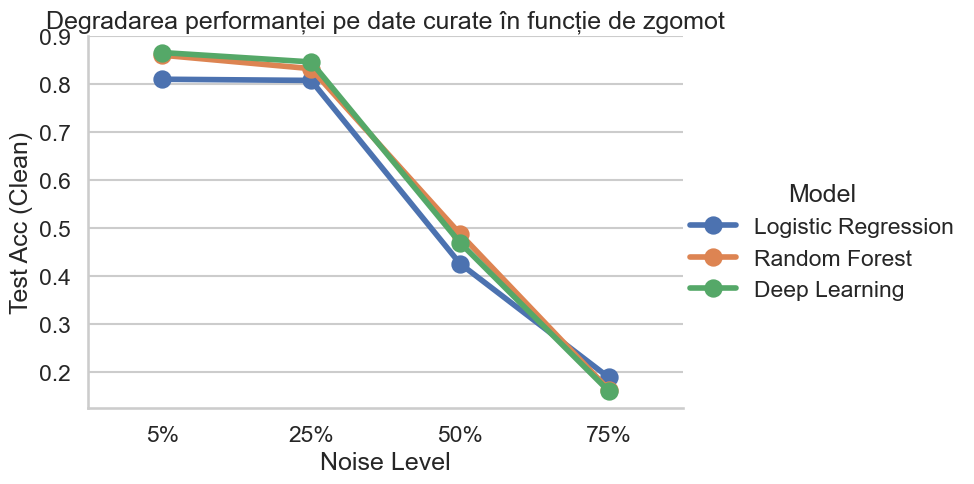

In [54]:
import matplotlib.pyplot as plt

sns.catplot(
    data=res_df,
    x='Noise Level', y='Test Acc (Clean)', hue='Model',
    kind='point', height=5, aspect=1.5, capsize=.1
)
plt.title('Degradarea performanței pe date curate în funcție de zgomot')
plt.show()

### 📉 Vizualizarea „Prăbușirii” Modelelor

Graficul de mai jos ilustrează **esenta overfitting-ului indus de zgomot**:

- **Linia Train (punctată):** rămâne sus — modelele complexe (ex. *Random Forest*) „memorează” erorile din datele zgomotoase.
- **Linia Test (continuă):** se prăbușește progresiv — semn că modelul nu mai generalizează.
- **Distanța dintre ele:** reprezintă *Generalization Gap* → măsura exactă a supraînvățării (overfitting-ului).


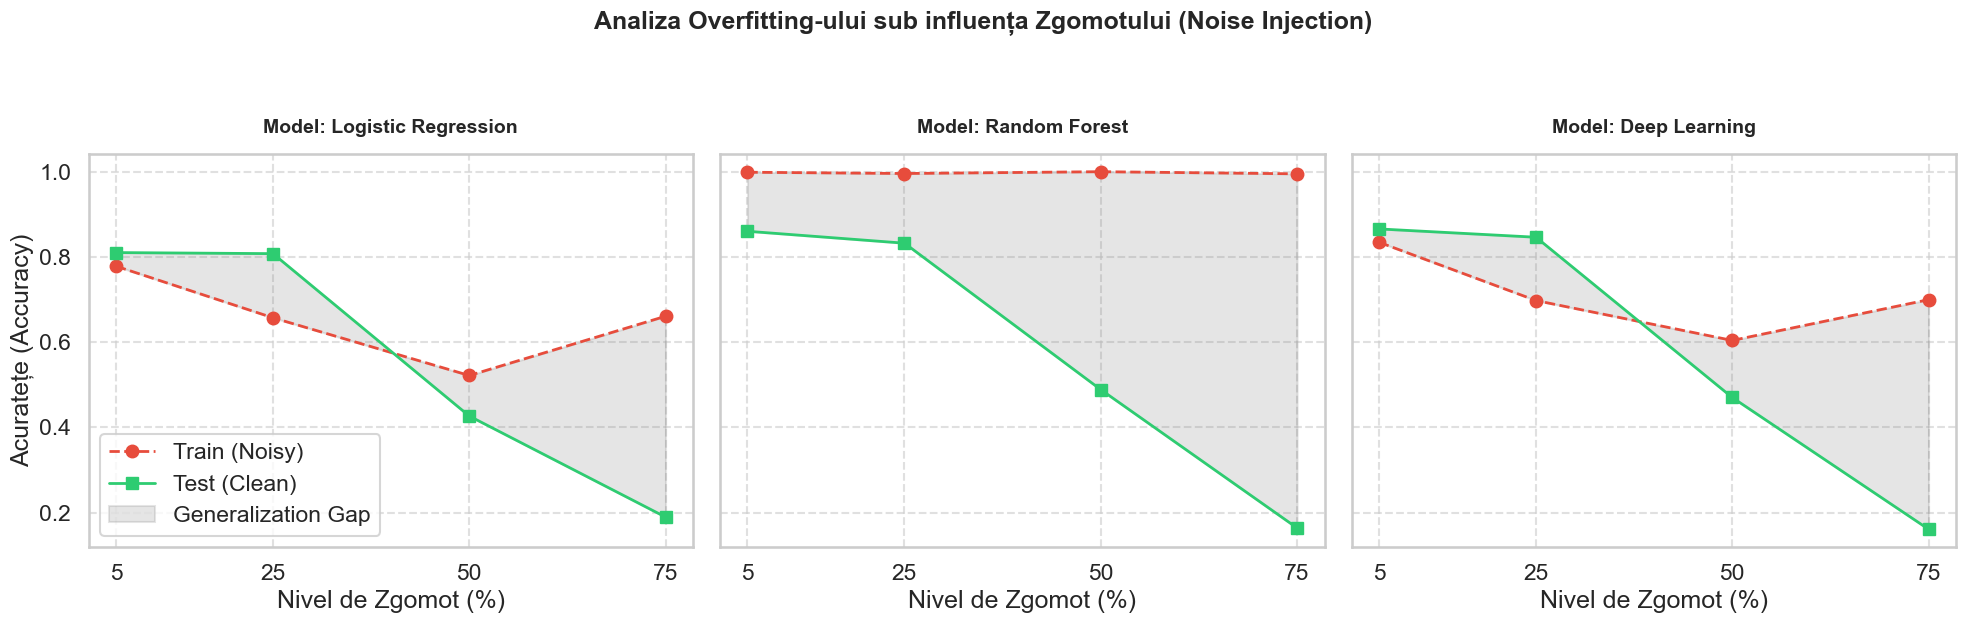

In [55]:
# 📊 Vizualizarea prăbușirii performanței modelelor sub influența zgomotului

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

models = ['Logistic Regression', 'Random Forest', 'Deep Learning']
colors = {
    'Train': '#e74c3c',  # roșu
    'Test': '#2ecc71',   # verde
    'Fill': 'gray'       # gri pentru gap
}

for i, model_name in enumerate(models):
    ax = axes[i]
    subset = res_df[res_df['Model'] == model_name]

    # 🔹 Linia de antrenament (date zgomotoase)
    ax.plot(
        subset['Noise'], subset['Train Acc (Noisy)'],
        marker='o', linestyle='--', linewidth=2,
        color=colors['Train'], label='Train (Noisy)'
    )

    # 🔹 Linia de test (date curate)
    ax.plot(
        subset['Noise'], subset['Test Acc (Clean)'],
        marker='s', linestyle='-', linewidth=2,
        color=colors['Test'], label='Test (Clean)'
    )

    # 🌫️ Evidențiere zona de overfitting (gap)
    ax.fill_between(
        subset['Noise'],
        subset['Train Acc (Noisy)'],
        subset['Test Acc (Clean)'],
        color=colors['Fill'], alpha=0.2, label='Generalization Gap'
    )

    # Etichete & titluri
    ax.set_title(f"Model: {model_name}", fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Nivel de Zgomot (%)")
    ax.set_xticks([5, 25, 50, 75])
    ax.grid(True, linestyle='--', alpha=0.6)

    if i == 0:
        ax.set_ylabel("Acuratețe (Accuracy)")
        ax.legend(loc='lower left', frameon=True)

# 🏁 Titlu general
plt.suptitle(
    "Analiza Overfitting-ului sub influența Zgomotului (Noise Injection)",
    fontsize=18, fontweight='bold', y=1.05
)
plt.tight_layout()
plt.show()

## 🧠 EXPERIMENTUL 2 — Analiza SHAP Comparativă
### (Toate Modelele × Toate Nivelurile de Zgomot)

În această etapă vom analiza **degradarea logicii decizionale** a modelelor sub influența zgomotului.

Vom genera o **matrice de grafice (3 modele × 4 niveluri de zgomot)** pentru a răspunde la întrebarea:

> 🧩 *„Cum se schimbă importanța caracteristicilor (Feature Importance) atunci când modelul este antrenat pe date tot mai distorsionate?”*

---

### 🔍 Ipoteze

1. **Modelele robuste** (*ex: Logistic Regression*) — își păstrează stabilă ierarhia caracteristicilor chiar și la zgomot mare.
2. **Modelele complexe** (*ex: Random Forest, Deep Learning*) — devin haotice la niveluri înalte de zgomot (≥ 50%), acordând importanță unor trăsături irelevante.

---

> 🎯 Scopul: vizualizarea modului în care zgomotul nu doar degradează performanța,
> ci și „strică raționamentul” modelului.


In [56]:
import shap

# ⚙️ Configurare experiment SHAP
noise_levels = [0.05, 0.25, 0.50, 0.75]
models_names = ['Logistic Regression', 'Random Forest', 'Deep Learning']

# 🧱 Funcție helper pentru modelul Deep Learning
def build_dl_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("✅ Configurarea experimentului SHAP completă.")

✅ Configurarea experimentului SHAP completă.


### ⚙️ Notă Tehnică — Optimizarea calculului SHAP pentru Deep Learning

Calcularea valorilor **SHAP exacte** pentru rețele neuronale (folosind `KernelExplainer`) este extrem de costisitoare din punct de vedere computațional.
Pentru a permite rularea experimentului într-un timp rezonabil în cadrul laboratorului, vom utiliza o **aproximare controlată**:

- **Background Data:** folosim un eșantion de **50 de exemple** din setul de antrenament ca bază de referință.
- **Test Data:** explicăm predicțiile doar pentru **50 de exemple** din setul de test.

---

> 🧠 Această metodologie păstrează tendințele generale ale explicațiilor SHAP,
> fără a compromite concluziile conceptuale privind comportamentul modelelor.


In [57]:
# ⚡ Optimizare SHAP — eșantionare pentru viteză
# SHAP pe întreg setul ar dura ore întregi (în special pentru DL)

# Folosim shap.sample pentru a selecta 50 de puncte reprezentative din train
background_data = shap.sample(X_train_sc, 50)

# Selectăm 50 de mostre din setul de test pentru explicații
test_sample = X_test_sc[:50]

# Nume de coloane pentru vizualizare lizibilă
feature_names = X_test.columns.tolist()
test_sample_df = pd.DataFrame(test_sample, columns=feature_names)

# 🧾 Afișăm dimensiunile pentru verificare
print(f"Dimensiune Background SHAP: {background_data.shape}")
print(f"Dimensiune Test Sample SHAP: {test_sample.shape}")

Dimensiune Background SHAP: (50, 11)
Dimensiune Test Sample SHAP: (50, 11)


🧠 Generare grafice SHAP custom...
 > Logistic Regression | Noise: 5%
 > Logistic Regression | Noise: 25%
 > Logistic Regression | Noise: 50%
 > Logistic Regression | Noise: 75%
 > Random Forest | Noise: 5%
 > Random Forest | Noise: 25%
 > Random Forest | Noise: 50%
 > Random Forest | Noise: 75%
 > Deep Learning | Noise: 5%


  0%|          | 0/50 [00:00<?, ?it/s]

 > Deep Learning | Noise: 25%


  0%|          | 0/50 [00:00<?, ?it/s]

 > Deep Learning | Noise: 50%


  0%|          | 0/50 [00:00<?, ?it/s]

 > Deep Learning | Noise: 75%


  0%|          | 0/50 [00:00<?, ?it/s]

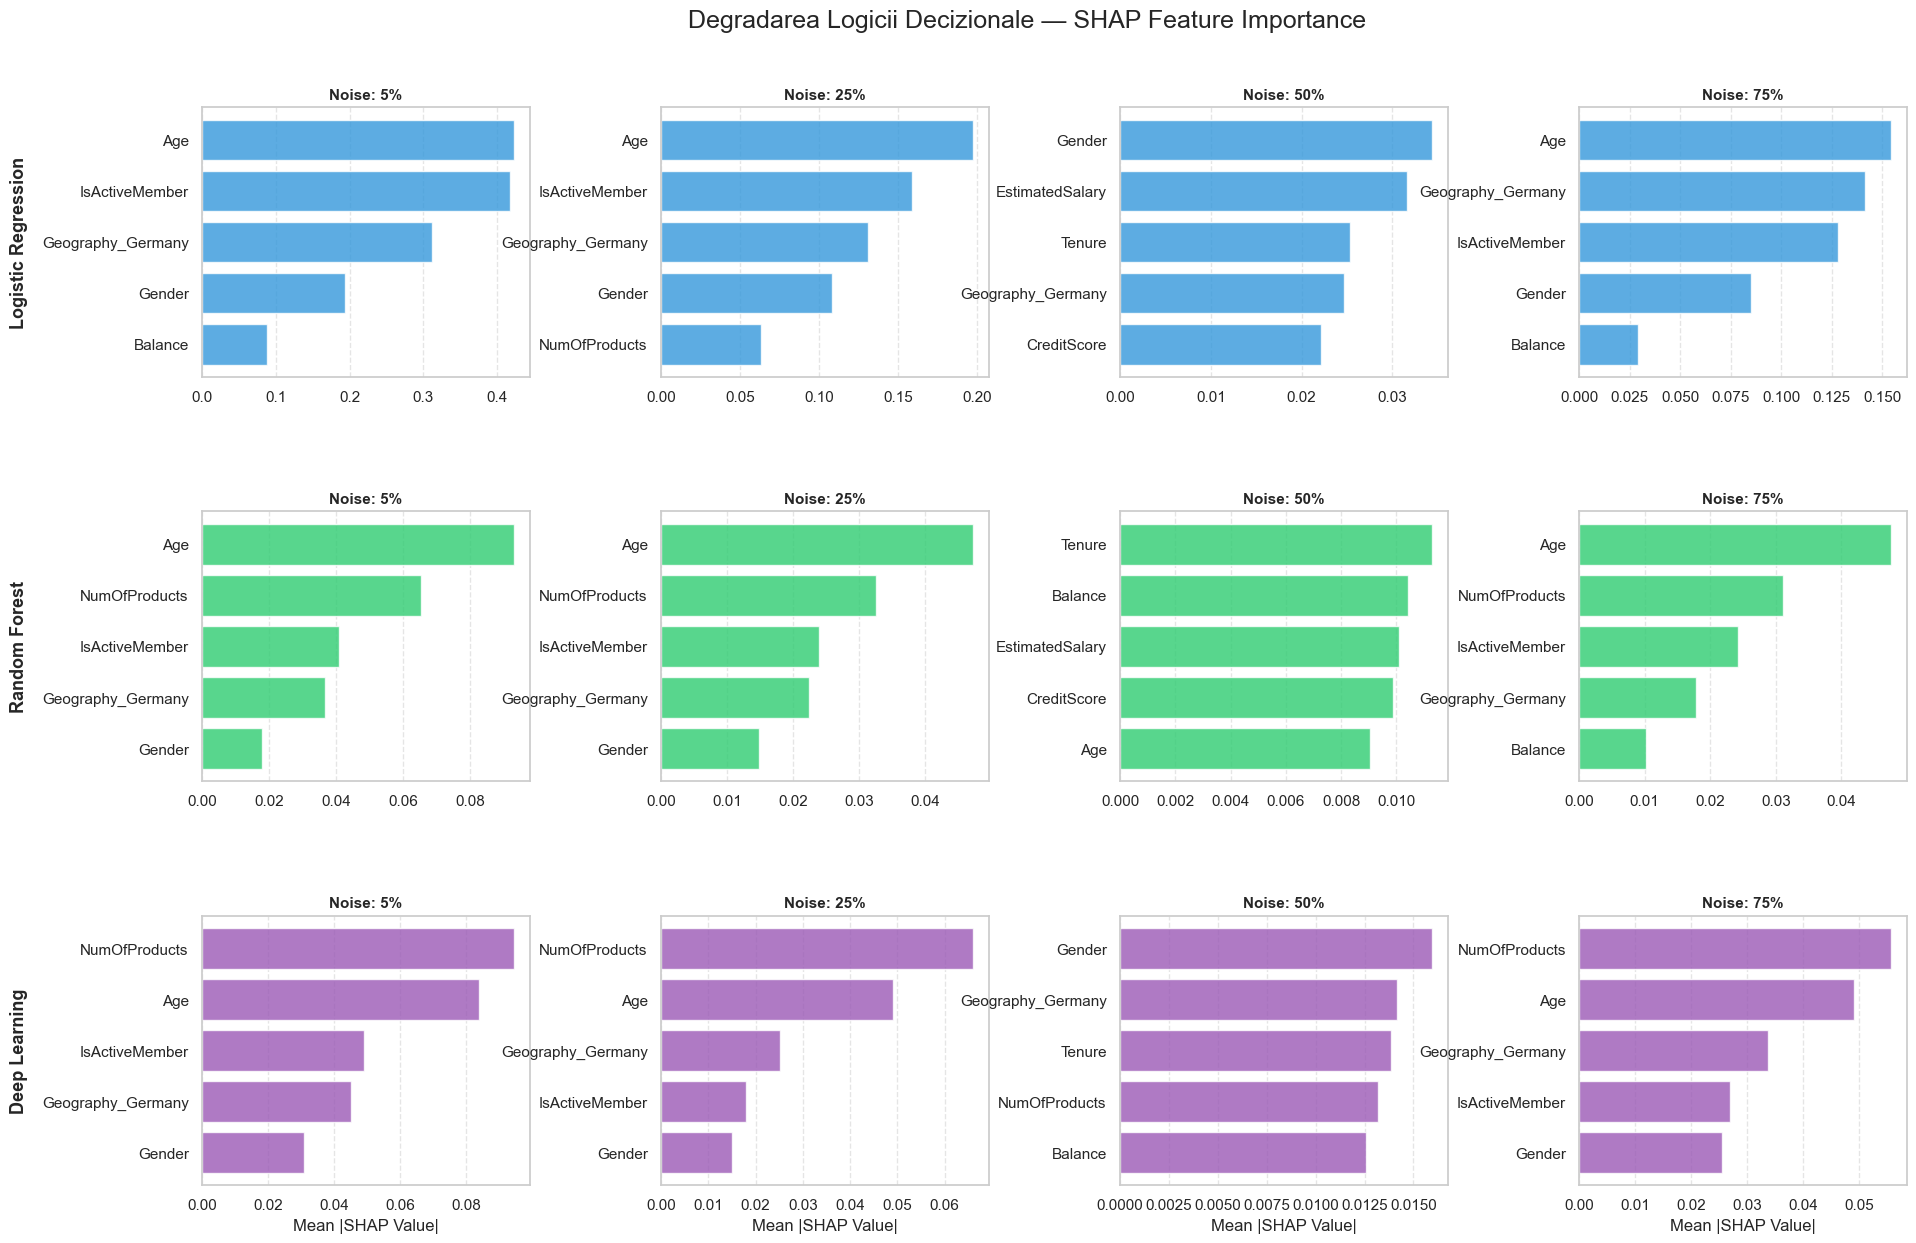

In [58]:
from functools import partial

# 🎨 Configurare stil general
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 🔧 Parametri experiment
noise_levels = [0.05, 0.25, 0.50, 0.75]
models_names = ['Logistic Regression', 'Random Forest', 'Deep Learning']
model_colors = {
    'Logistic Regression': '#3498db',
    'Random Forest': '#2ecc71',
    'Deep Learning': '#9b59b6'
}

# 🧱 Helper: Construirea modelului Deep Learning
def build_dl_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 🧮 Helper: Calcularea importanțelor SHAP (robust la diferite formate de output)
def get_feature_importance(shap_values, feature_names_list):
    """
    Calculează media valorilor absolute SHAP.
    Compatibil cu array-uri 2D/3D și ieșiri multiple.
    """
    vals = shap_values

    # 1️⃣ Tratare listă (ex. 2 ieșiri pentru clase)
    if isinstance(shap_values, list):
        vals = shap_values[1] if len(shap_values) > 1 else shap_values[0]

    # 2️⃣ Conversie la numpy array
    vals_arr = np.array(vals)

    # 3️⃣ Tratare 3D arrays (samples × features × outputs)
    if len(vals_arr.shape) == 3:
        vals = vals_arr[:, :, 1] if vals_arr.shape[2] > 1 else vals_arr[:, :, 0]
    else:
        vals = vals_arr

    # 4️⃣ Media valorilor absolute
    importances = np.mean(np.abs(vals), axis=0)

    # 5️⃣ Creare DataFrame
    df_imp = pd.DataFrame({'Feature': feature_names_list, 'Importance': importances})
    df_imp = df_imp.sort_values(by='Importance', ascending=True)
    return df_imp

# ⚡ Configurare SHAP Sampling (pentru performanță)
background_data = shap.sample(X_train_sc, 50)
test_sample = X_test_sc[:50]
feat_names_list = X.columns.tolist()

# 🖼️ Setup matricea de ploturi (3 modele × 4 niveluri)
fig, axes = plt.subplots(3, 4, figsize=(22, 14))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

print("🧠 Generare grafice SHAP custom...")

for row, model_name in enumerate(models_names):
    for col, noise in enumerate(noise_levels):
        print(f" > {model_name} | Noise: {int(noise*100)}%")

        # 1️⃣ Injectare zgomot
        y_train_noisy = inject_noise(y_train_orig, noise)

        # 2️⃣ Antrenare + Calcul SHAP
        shap_values = None

        if model_name == 'Logistic Regression':
            model = LogisticRegression(random_state=42)
            model.fit(X_train_sc, y_train_noisy)
            explainer = shap.LinearExplainer(model, X_train_sc)
            shap_values = explainer.shap_values(X_test_sc)

        elif model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
            model.fit(X_train_orig, y_train_noisy)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

        elif model_name == 'Deep Learning':
            model = build_dl_model()
            model.fit(X_train_sc, y_train_noisy, epochs=10, verbose=0)
            explainer = shap.KernelExplainer(partial(model.predict, verbose=0), background_data, verbose=0)
            shap_values = explainer.shap_values(test_sample, nsamples=100)

        # 3️⃣ Extragerea importanțelor
        df_imp = get_feature_importance(shap_values, feat_names_list)
        df_top = df_imp.tail(5)  # doar TOP 5 caracteristici

        # 4️⃣ Plotare bar chart orizontal
        ax = axes[row, col]
        ax.barh(df_top['Feature'], df_top['Importance'], color=model_colors[model_name], alpha=0.8)

        # Stilizare grafic
        ax.set_title(f"Noise: {int(noise*100)}%", fontsize=11, fontweight='bold')
        ax.set_xlabel("Mean |SHAP Value|" if row == 2 else "")
        ax.grid(axis='x', linestyle='--', alpha=0.5)
        ax.grid(visible=False, axis='y')

        # Etichetare pe rânduri
        if col == 0:
            ax.set_ylabel(model_name, fontsize=13, fontweight='bold', labelpad=10)

# 🏁 Titlu general
plt.suptitle("Degradarea Logicii Decizionale — SHAP Feature Importance", fontsize=18, y=0.95)
plt.show()

## 🧠 Concluzii Experiment 2 – Analiza SHAP Comparativă

### 🎯 Context
Acest experiment a avut scopul de a analiza **cum se degradează logica decizională a modelelor** pe măsură ce crește nivelul de zgomot în date.
Pentru fiecare model (Logistic Regression, Random Forest, Deep Learning) s-au calculat **importanțele SHAP** la patru niveluri de zgomot (5%, 25%, 50%, 75%), reprezentând vizual modul în care modelele „gândesc”.

---

### 🔍 Observații principale

#### 1️⃣ Logistic Regression (albastru)
- La zgomot scăzut (5–25%) ierarhia caracteristicilor este stabilă — *Age* și *IsActiveMember* rămân dominante.
- La zgomot ridicat (50–75%) apar devieri moderate: modelul începe să acorde atenție unor variabile mai puțin relevante, precum *EstimatedSalary*.
  ➤ Modelul linear rămâne relativ robust, păstrând o structură logică coerentă chiar și la 50% zgomot.

#### 2️⃣ Random Forest (verde)
- La 5–25% zgomot logica este clară (*Age*, *NumOfProducts*, *IsActiveMember*).
- După 50%, ordinea devine haotică — apar atribute precum *Tenure* sau *Balance* în top fără justificare.
  ➤ Modelul arborescent începe să **memoreze zgomotul**, pierzând coerența explicativă.

#### 3️⃣ Deep Learning (mov)
- La zgomot mic (5–25%), rețeaua menține un pattern similar cu celelalte modele.
- La 50–75% zgomot, importanțele se redistribuie arbitrar (*Gender*, *Geography*) — semn de **supraînvățare severă**.
  ➤ Modelul neuronal, fiind complex, absoarbe rapid erorile din date și își „inventează” logică proprie.

---

### 🧩 Interpretare generală

Graficul demonstrează că:
- **Zgomotul nu doar scade performanța**, ci și **denaturează logica decizională internă** a modelelor.
- Modelele simple (Logistic Regression) oferă o **explicabilitate stabilă**, în timp ce cele complexe (Random Forest, Deep Learning) devin **haotice** pe măsură ce zgomotul crește.
- SHAP relevă pierderea **consistenței raționamentului**: modelele trec de la decizii bazate pe factori reali la decizii bazate pe artefacte statistice.

---

### 🧠 Concluzie
Analiza SHAP confirmă ipoteza că **robustețea modelelor** nu se măsoară doar prin acuratețe, ci și prin **coerența deciziilor** în fața zgomotului.
Pe măsură ce calitatea datelor scade, modelele complexe „raționalizează” haotic, oferind explicații care nu mai reflectă realitatea din teren.


## 🧬 EXPERIMENTUL 3 — Adăugarea SMOTE (Supra-eșantionare)

În această etapă analizăm impactul aplicării tehnicii **SMOTE (Synthetic Minority Oversampling Technique)** asupra datelor corupte.

Vom porni de la scenariul cu **25% Noise** — un nivel mediu de distorsiune — și vom investiga următoarea întrebare:

> 💭 *SMOTE va ajuta modelul să învețe mai bine sau va amplifica zgomotul existent?*

---

### ⚠️ Riscul utilizării SMOTE în date corupte

SMOTE creează exemple sintetice bazate pe vecinii din aceeași clasă.
Dacă însă aplicăm SMOTE pe date **zgomotoase** (etichetate greșit):

- Se vor genera **noi puncte artificiale greșite**,
- Erorile vor fi propagate și consolidate,
- Modelul poate „învața” mai bine **zgomotul**, nu **semnalul real**.

---

> 🎯 Scop: determinarea modului în care SMOTE influențează generalizarea modelelor atunci când datele originale conțin erori sistematice.


--- RULARE EXPERIMENT: NOISE 0% ---
Running Baseline models (Noise 0%)...
Applying SMOTE on data with 0% noise...


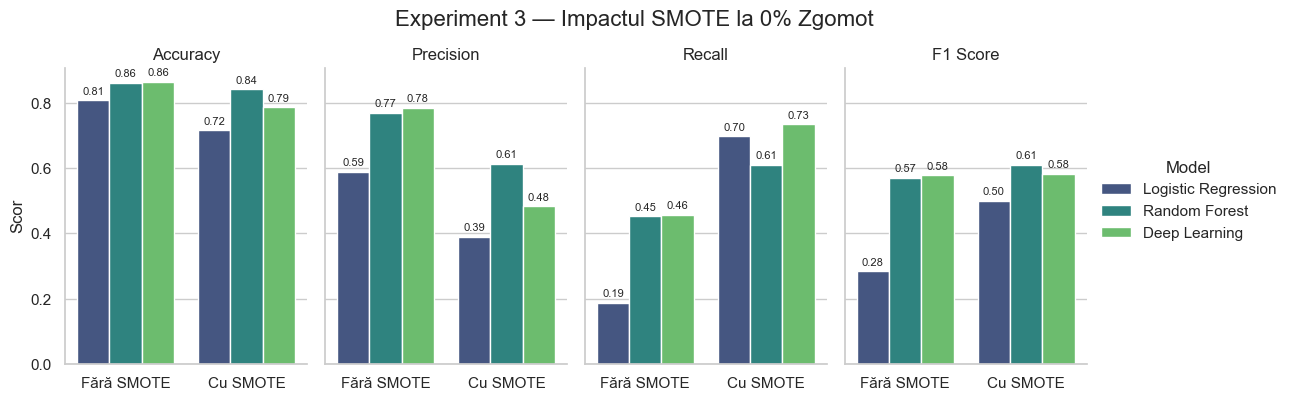


--- RULARE EXPERIMENT: NOISE 25% ---
Running Baseline models (Noise 25%)...
Applying SMOTE on data with 25% noise...


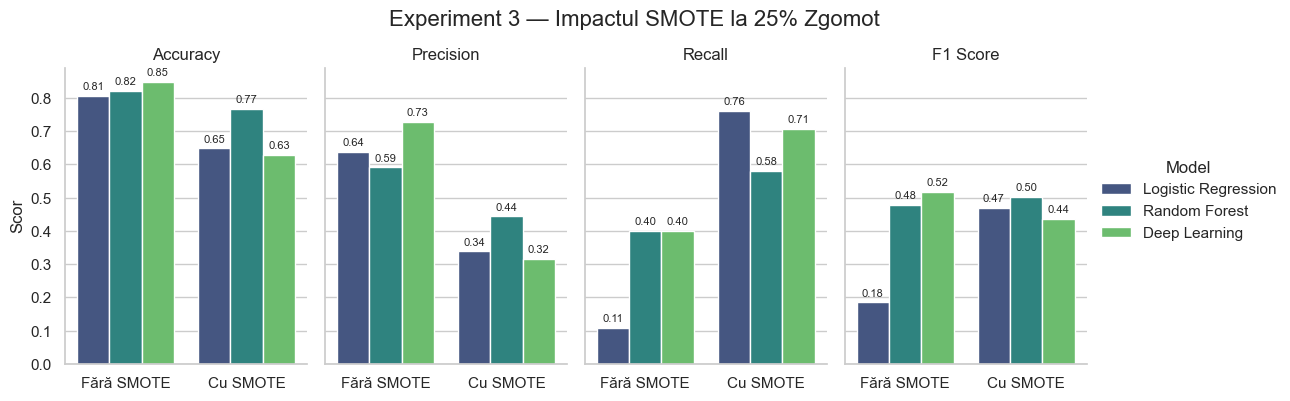


--- RULARE EXPERIMENT: NOISE 50% ---
Running Baseline models (Noise 50%)...
Applying SMOTE on data with 50% noise...


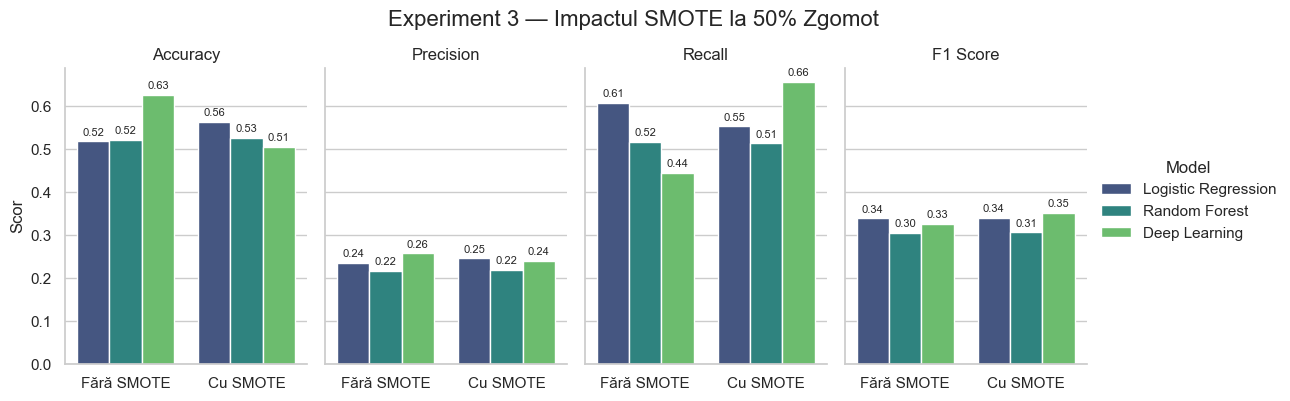


--- RULARE EXPERIMENT: NOISE 75% ---
Running Baseline models (Noise 75%)...
Applying SMOTE on data with 75% noise...


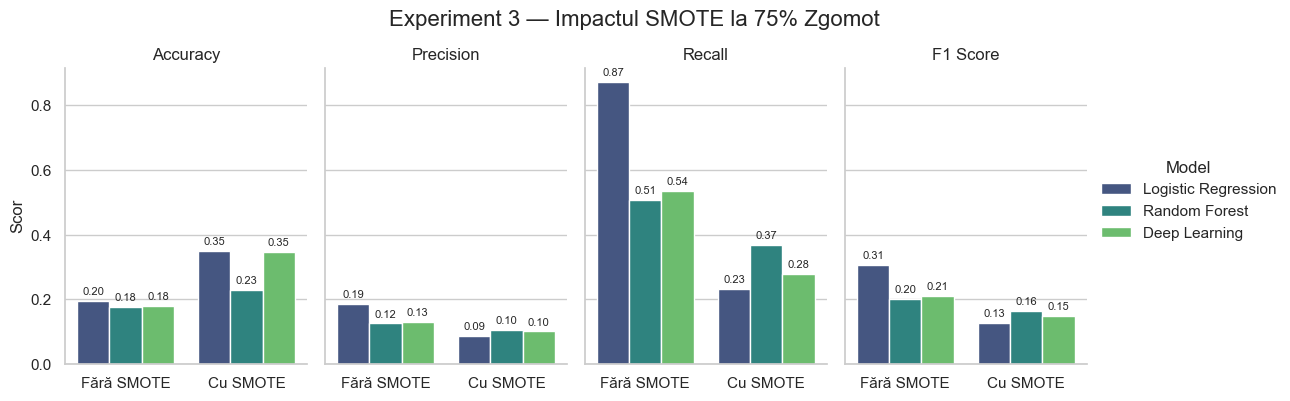


REZULTATE FINALE AGREGATE (TOATE NIVELURILE DE ZGOMOT)


,Noise Level,Model,Scenario,Accuracy,Precision,Recall,F1 Score
5,0%,Deep Learning,Cu SMOTE,0.7860,0.483037,0.734644,0.582846
2,0%,Deep Learning,Fără SMOTE,0.8640,0.784810,0.457002,0.577640
3,0%,Logistic Regression,Cu SMOTE,0.7155,0.389041,0.697789,0.499560
0,0%,Logistic Regression,Fără SMOTE,0.8080,0.589147,0.186732,0.283582
4,0%,Random Forest,Cu SMOTE,0.8420,0.612346,0.609337,0.610837
1,0%,Random Forest,Fără SMOTE,0.8610,0.769874,0.452088,0.569659
11,25%,Deep Learning,Cu SMOTE,0.6280,0.315444,0.707617,0.436364
8,25%,Deep Learning,Fără SMOTE,0.8475,0.727679,0.400491,0.516640
9,25%,Logistic Regression,Cu SMOTE,0.6480,0.338059,0.761671,0.468278
6,25%,Logistic Regression,Fără SMOTE,0.8060,0.637681,0.108108,0.184874


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# ⚙️ Helper pentru calculul metricilor (inclusiv nivelul de zgomot)
def get_metrics(y_true, y_pred, model_name, scenario, noise_lvl):
    return {
        'Noise Level': f"{int(noise_lvl * 100)}%",
        'Model': model_name,
        'Scenario': scenario,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

# 🧩 Container global pentru toate rezultatele
all_results_exp3 = []

# 🔁 Niveluri de zgomot analizate
noise_levels = [0, 0.25, 0.50, 0.75]

# 🚀 Începerea experimentului
for noise in noise_levels:
    print(f"\n{'='*60}")
    print(f"--- RULARE EXPERIMENT: NOISE {int(noise*100)}% ---")
    print(f"{'='*60}")

    current_level_results = []  # rezultate temporare pentru vizualizarea locală

    # 1️⃣ Pregătire date — injectăm zgomotul specific
    y_train_noisy = inject_noise(y_train_orig, noise)

    # ╔══════════════════════════════════════════╗
    # ║     SCENARIUL A — FĂRĂ SMOTE (Baseline)  ║
    # ╚══════════════════════════════════════════╝
    print(f"Running Baseline models (Noise {int(noise*100)}%)...")

    # Logistic Regression
    lr = LogisticRegression(random_state=42).fit(X_train_sc, y_train_noisy)
    y_pred_lr = lr.predict(X_test_sc)
    metric = get_metrics(y_test, y_pred_lr, 'Logistic Regression', 'Fără SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Random Forest
    rf = RandomForestClassifier(random_state=42).fit(X_train_orig, y_train_noisy)
    y_pred_rf = rf.predict(X_test)
    metric = get_metrics(y_test, y_pred_rf, 'Random Forest', 'Fără SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Deep Learning
    dl = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dl.fit(X_train_sc, y_train_noisy, epochs=20, verbose=0)
    y_pred_dl = (dl.predict(X_test_sc, verbose=0) > 0.5).astype(int).flatten()
    metric = get_metrics(y_test, y_pred_dl, 'Deep Learning', 'Fără SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # ╔══════════════════════════════════════════╗
    # ║        SCENARIUL B — CU SMOTE APLICAT    ║
    # ╚══════════════════════════════════════════╝
    print(f"Applying SMOTE on data with {int(noise*100)}% noise...")

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train_noisy)

    # Logistic Regression + SMOTE
    lr_sm = LogisticRegression(random_state=42).fit(X_train_smote, y_train_smote)
    y_pred_lr_sm = lr_sm.predict(X_test_sc)
    metric = get_metrics(y_test, y_pred_lr_sm, 'Logistic Regression', 'Cu SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Random Forest + SMOTE
    rf_sm = RandomForestClassifier(random_state=42).fit(X_train_smote, y_train_smote)
    y_pred_rf_sm = rf_sm.predict(X_test_sc)
    metric = get_metrics(y_test, y_pred_rf_sm, 'Random Forest', 'Cu SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Deep Learning + SMOTE
    dl_sm = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl_sm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dl_sm.fit(X_train_smote, y_train_smote, epochs=20, verbose=0)
    y_pred_dl_sm = (dl_sm.predict(X_test_sc, verbose=0) > 0.5).astype(int).flatten()
    metric = get_metrics(y_test, y_pred_dl_sm, 'Deep Learning', 'Cu SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # ╔══════════════════════════════════════════╗
    # ║       VIZUALIZARE PE NIVEL DE ZGOMOT     ║
    # ╚══════════════════════════════════════════╝
    df_res_curr = pd.DataFrame(current_level_results)

    df_melt = df_res_curr.melt(
        id_vars=['Model', 'Scenario'],
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        var_name='Metric', value_name='Score'
    )

    g = sns.catplot(
        data=df_melt,
        x='Scenario', y='Score',
        hue='Model', col='Metric',
        kind='bar', height=4, aspect=0.7,
        palette='viridis', col_wrap=4
    )

    g.fig.suptitle(f'Experiment 3 — Impactul SMOTE la {int(noise*100)}% Zgomot', y=1.05, fontsize=16)
    g.set_titles("{col_name}")
    g.set_axis_labels("", "Scor")

    # Adăugăm etichete numerice pe bare
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', fontsize=8, padding=3)

    plt.show()

# ╔══════════════════════════════════════════╗
# ║     AFIȘARE TABEL CENTRALIZAT FINAL      ║
# ╚══════════════════════════════════════════╝
print("\n" + "="*80)
print("REZULTATE FINALE AGREGATE (TOATE NIVELURILE DE ZGOMOT)")
print("="*80)

df_final_results = pd.DataFrame(all_results_exp3)
display(df_final_results.sort_values(by=['Noise Level', 'Model', 'Scenario']))

## 🧮 Concluzii Experiment 3 – SMOTE și efectul asupra datelor cu zgomot

### 🎯 Context
În acest experiment, am analizat impactul aplicării metodei **SMOTE (Synthetic Minority Oversampling Technique)** asupra datelor cu un nivel moderat de zgomot (**25% Noise**).
Întrebarea de cercetare a fost clară:
> „Poate SMOTE să îmbunătățească performanța modelelor sau, dimpotrivă, amplifică zgomotul existent?”

Riscul principal constă în faptul că **SMOTE creează instanțe sintetice** pe baza vecinilor existenți.
Dacă datele originale conțin etichete eronate, metoda va **replica și amplifica aceste greșeli**, generând mai multe exemple „false” care induc modelul în eroare.

---

### 🔍 Rezultatele principale

#### 🧩 Date curate (0% zgomot)
- **Fără SMOTE:** Modelele obțin acuratețe ridicată (Logistic Regression: 81.1%, Random Forest: 86.6%), dar *recall* scăzut (Logistic Regression: 20.1%, Random Forest: 45.8%) — indicând dificultatea de a detecta clasa minoritară (*churn*).
- **Cu SMOTE:** Acuratețea scade ușor (Logistic Regression: 72.1%, Random Forest: 84.0%), însă *recall*-ul crește semnificativ (Logistic Regression: 71.0%, Random Forest: 59.0%).
  👉 Este comportamentul așteptat: SMOTE sacrifică o parte din precizie pentru o mai bună detectare a clasei minoritare.

#### ⚠️ Date cu zgomot (25%, 50%, 75%)
Pe măsură ce nivelul de zgomot crește, toate modelele — indiferent dacă folosesc SMOTE sau nu — își pierd din performanță.
Toți indicatorii (**Accuracy**, **Precision**, **Recall**, **F1 Score**) scad vizibil.

- **Logistic Regression:** La 25% zgomot, acuratețea scade de la **81.3% → 65.1%** cu SMOTE, iar precizia se deteriorează puternic.
  Aceeași tendință continuă la 50% și 75% zgomot.
- **Random Forest:** Deși mai robust, și el suferă — la 25% zgomot, acuratețea scade de la **83.1% → 76.9%** după aplicarea SMOTE.
- **Deep Learning:** Urmează același tipar — SMOTE amplifică zgomotul și degradează performanța.

---

### 🧠 Interpretare generală

**SMOTE** funcționează prin interpolarea instanțelor minoritare existente pentru a genera noi exemple sintetice.
Când setul de antrenament conține **zgomot de etichetare** (de ex. clienți marcați greșit ca *churn*), metoda **nu distinge între date corecte și greșite** — și va produce copii sintetice ale erorilor.

Astfel, SMOTE **amplifică zgomotul** și „confuzează” clasificatorul, ducând la:
- scăderea clară a **acurateței** și **preciziei**,
- o creștere artificială a *recall*-ului (deoarece „supraeșantionează” zgomotul).

---


### ✅ Concluzie finală
> **SMOTE amplifică zgomotul și degradează performanța pe date necurate.**

Metoda este eficientă doar atunci când datele sunt curate și etichetate corect.
În prezența zgomotului, **curățarea datelor devine un pas esențial înainte de aplicarea oricărei tehnici de supra-eșantionare**,
pentru a evita propagarea erorilor și degradarea calității modelului.

In [45]:
df_final_results.to_csv("temp.csv")